If not already installed first install wordcloud by following these steps in terminal:

    git clone https://github.com/amueller/word_cloud.git
    cd word_cloud
    pip install .

Import all required modules.

In [25]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
import operator
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from wordcloud import WordCloud

from sklearn.metrics import f1_score

import numpy.ma as ma

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /Users/bryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/bryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Below we implement a class to make classifications using Multinomial Naive Bayes.

In [26]:
# 1 is spam
# 0 is Ham

class MultiNomial_NB():
    
    def __init__(self,alpha=1.0):
        self.alpha=alpha
    
    # Definition to fit data
    def fit(self,X,Y):
        # First find prior probability for each class (1 first)
        spam_mat=X[Y[:,0]==1]
        ham_mat = X[Y[:,0]==0]
        num_in_spam = spam_mat.sum() # Number of words in spam
        num_in_ham = ham_mat.sum() # Number of words in ham
        num_in_total = num_in_spam + num_in_ham
        word_freq_in_spam_array = spam_mat.sum(axis=0)
        word_freq_in_ham_array = ham_mat.sum(axis=0)
        
        self.class_prior_spam = (self.alpha+num_in_spam)/(num_in_total+self.alpha*2)
        self.class_prior_ham = (self.alpha+num_in_ham)/(num_in_total+self.alpha*2)
        
        self.likelihood_spam=np.empty([X.shape[1],1])
        self.likelihood_ham=np.empty([X.shape[1],1])
        self.likelihood_log_spam=np.empty([X.shape[1],1])
        self.likelihood_log_ham=np.empty([X.shape[1],1])
        self.likelihood_log_1minus_spam=np.empty([X.shape[1],1])
        self.likelihood_log_1minus_ham=np.empty([X.shape[1],1])
        
        for i in range(X.shape[1]):
            self.likelihood_spam[i] = (self.alpha+word_freq_in_spam_array[i])/(num_in_spam+alpha*X.shape[1])
            self.likelihood_ham[i] = (self.alpha+word_freq_in_ham_array[i])/(num_in_ham+alpha*X.shape[1])
            # For use in predictions calculate Log of self.likelihood functions
            self.likelihood_log_spam[i] = math.log(self.likelihood_spam[i])
            self.likelihood_log_ham[i] = math.log(self.likelihood_ham[i])
            # For use in predictions calculate Log of 1-self.likelihood functions
            self.likelihood_log_1minus_spam[i] = math.log(1-self.likelihood_spam[i])
            self.likelihood_log_1minus_ham[i] = math.log(1-self.likelihood_ham[i])
        
    # Makes a prediction on which class each message most likely belongs to
    def predict(self,X):
        # Call other class function
        # Each row is a message
        # Column 0 holds log-probability of belong to class ham
        # Column 1 holds log-probability of belonging to class spam
        predict_prob_array = self.predict_log_proba(X) # Use log-probabilities
#         predict_prob_array = self.predict_proba(X)# Use multiplicative probabilities
        
        predictions = np.empty([predict_prob_array.shape[0],1])
        for i in range(predict_prob_array.shape[0]): # Go through each message
            if predict_prob_array[i,1]>predict_prob_array[i,0]:
                predictions[i] = 1 # Classify as spam
            else:
                predictions[i] = 0 # Classify as ham
        return predictions
    
    # This returns the probability of each class
    def predict_proba(self,X):
        # Go through each message one at a time
        predict_prob_array = np.empty([X.shape[0],2])
        for i in range(X.shape[0]):
            # Initialize to start off with just class prior
            prob_spam = self.class_prior_spam
            prob_ham = self.class_prior_ham
            for j in range(X.shape[1]): # Go through each feature now
                if X[i,j]>0:
                    prob_spam = prob_spam*self.likelihood_spam[j]
                    prob_ham = prob_ham*self.likelihood_ham[j]
                else:
                    prob_spam = prob_spam*(1-self.likelihood_spam[j])
                    prob_ham = prob_ham*(1-self.likelihood_ham[j])
                    
            # Now add to main probability array (put spam in column 1 as it is indicated with a 1)
            predict_prob_array[i,1] = prob_spam
            predict_prob_array[i,0] = prob_ham               
        return predict_prob_array
    
    # This returns the log probability of each class
    def predict_log_proba(self,X):
        # Go through each message one at a time
        predict_log_prob_array = np.empty([X.shape[0],2])

        mask = X!=0
        for i in range(X.shape[0]): # Go through each message
            curr_mask = mask[i,:]
            
            words_log_spam = self.likelihood_log_spam[curr_mask]
            no_words_log_spam = self.likelihood_log_1minus_spam[~curr_mask]
            prob_spam = math.log(self.class_prior_spam)+sum(words_log_spam)+sum(no_words_log_spam)
            
            words_log_ham = self.likelihood_log_ham[curr_mask]
            no_words_log_ham = self.likelihood_log_1minus_ham[~curr_mask]
            prob_ham = math.log(self.class_prior_ham)+sum(words_log_ham)+sum(no_words_log_ham)
                    
            # Now add to main probability array (put spam in column 1 as it is indicated with a 1)
            predict_log_prob_array[i,1] = prob_spam
            predict_log_prob_array[i,0] = prob_ham
            
        return predict_log_prob_array

Create definition to partition data into training and testing sets.

In [27]:
def partition(X,Y,t,random_state):
    np.random.seed(seed=random_state)
    num_rows = X.shape[0]
    test_size = int(t * num_rows)
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    test_rows = row_vec[0 : test_size]
    
    train_rows = row_vec[test_size+1:len(row_vec)-1]
    
    # Now define x and y for training and testing
    X_test = X[test_rows,:]
    X_train = X[train_rows,:]
    Y_test = Y[test_rows]
    Y_train = Y[train_rows]
    return X_test,X_train,Y_test,Y_train

We now read in the spam database.

In [28]:
file_name='SMSSpamCollection.csv'#change file name

# Read in data into pandas dataframe
df=pd.read_csv(file_name,names = ["Labels", "Message"])

print(df.shape)
df.head()

(5574, 2)


,Labels,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Below I look at a statistical summary of the labels (0 or 1) in my dataset

In [29]:
df.describe()

,Labels,Message
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


We now create a bar plot of for the classes in the dataframe (spam or not spam)

ham     4827
spam     747
Name: Labels, dtype: int64


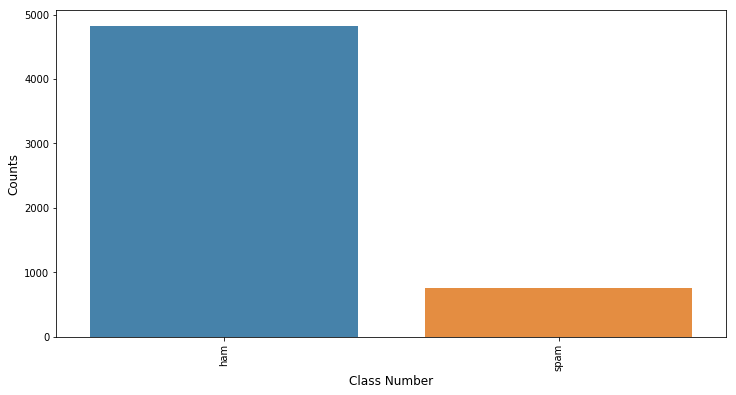

In [30]:
# Count up number of times each class occurs
label_counts = df['Labels'].value_counts()

print(label_counts)
# Plot the frequency found above in a histogram to visualize number of emails corresponding to categories
# Note the categories chosen have been shuffled, so we do not know which number corresponds to which category

plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Class Number', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

Change labels from spam to 1 and from ham to 0 for easier computation.

In [31]:
# Before feature extraction we rename labels to 1=spam and 0=ham
df['Label'] = df['Labels'].map({'ham': 0, 'spam': 1})
df.drop(['Labels'], axis = 1, inplace = True)
df.head()

,Message,Label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


We now normalize using stemming or lemmatization.

In [32]:
# Initialize Lemmatizer and stemming
lemmatizer = WordNetLemmatizer()
stemmer_porter = PorterStemmer()
stemmer_lancaster=LancasterStemmer()

# Set stopwords to English
stops = set(stopwords.words('english'))

# Initialize Dataframes for all normalized messages
df_lemmatized = pd.DataFrame()
df_stemmer_porter = pd.DataFrame()
df_stemmer_lancaster = pd.DataFrame()
df_lemmatized_porter = pd.DataFrame()
df_lemmatized_lancaster = pd.DataFrame()
df_porter_lancaster = pd.DataFrame()

# Apply and store normalized messages in separate dataframes
df_lemmatized['Message'] = df['Message'].map(lambda text: lemmatizer.lemmatize(text))
df_stemmer_porter['Message']=df['Message'].map(lambda text: stemmer_porter.stem(text))
df_stemmer_lancaster['Message']=df['Message'].map(lambda text: stemmer_lancaster.stem(text))
# Below applies porter stemming on top of lemmatizing
df_lemmatized_porter['Message'] = df_lemmatized['Message'].map(lambda text: stemmer_porter.stem(text))
df_lemmatized_lancaster['Message'] = df_lemmatized['Message'].map(lambda text: stemmer_lancaster.stem(text))
# Below applies lancaster stemming on top of porter stemming
df_porter_lancaster['Message'] = df_stemmer_porter['Message'].map(lambda text: stemmer_lancaster.stem(text))

# Add column with class labels to each dataframe
df_lemmatized['Label']=df['Label']
df_stemmer_porter['Label']=df['Label']
df_stemmer_lancaster['Label']=df['Label']
df_lemmatized_porter['Label']=df['Label']
df_lemmatized_lancaster['Label']=df['Label']
df_porter_lancaster['Label']=df['Label']

Below choose which normalization type to use.<br>
Choose carefully as whatever is chosen here will be used below.

In [33]:
# df_norm = df # Unnormalized Messages
df_norm = df_lemmatized # Lemmatized Messages
# df_norm = df_stemmer_porter # Porter Stemmed Messages
# df_norm = df_stemmer_lancaster # Lancaster Stemmed Messages
# df_norm = df_lemmatized_porter # Lemmatized and Porter Stemmed Messages
# df_norm = df_lemmatized_lancaster # Lemmatized and Porter Stemmed Messages
# df_norm = df_porter_lancaster # Porter Stemmed and Lancaster Stemmed Messages

For fun we generate word clouds for spam emails and ham emails.

Below is the wordcloud for the observed spam emails


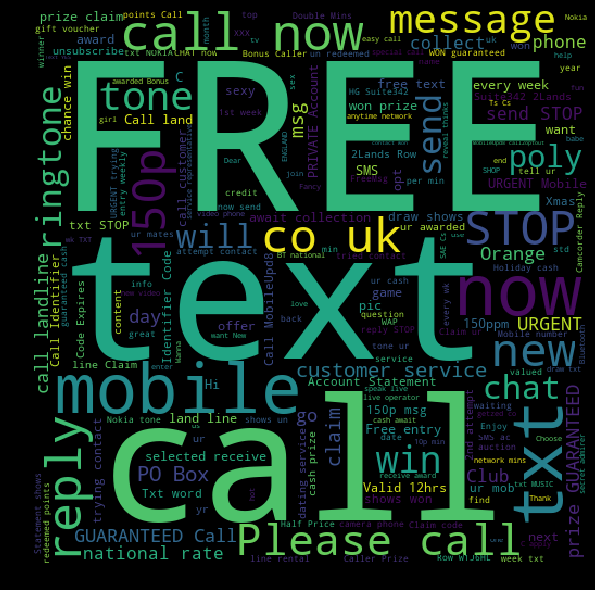

Below is the wordcloud for the observed ham emails


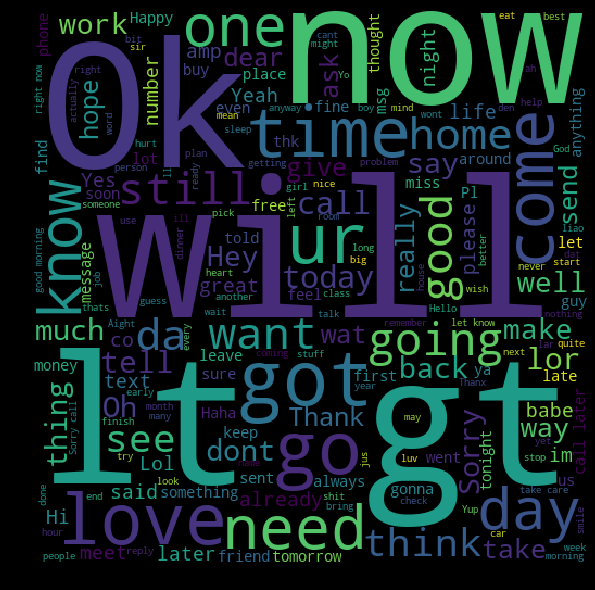

In [34]:
# Generate word clouds for spam emails
print('Below is the wordcloud for the observed spam emails')
spam_words = ' '.join(list(df_norm[df_norm['Label'] == 1]['Message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Generate word clouds for ham emails
print('Below is the wordcloud for the observed ham emails')
ham_words = ' '.join(list(df_norm[df_norm['Label'] == 0]['Message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Now shuffle the order of all messages to avoid bias.

In [35]:
# Shuffle the order of the rows
df_norm = df.sample(frac=1)
df_norm.head()

,Message,Label
2200,Not sure I have the stomach for it ...,0
33,For fear of fainting with the of all that hous...,0
1369,Alright. I'm out--have a good night!,0
3621,I meant as an apology from me for texting you ...,0
3273,"MOON has come to color your dreams, STARS to m...",0


Now remove stop words and count up all times unique words appear for each message.

In [36]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(df_norm['Message'])

# Below is a numpy ndarray
# Each row is for a different message
# Each column is a unique word
feature_matrix = vectorizer.transform(df_norm['Message']).toarray()
print(feature_matrix.shape)

(5574, 8471)


After performing vectorizing of my features I can now look at their statistical distribution. This is shown below.<br>
Note that each column corresponds to a unique word in the dictionary.

In [37]:
print(pd.DataFrame(feature_matrix).describe())

              0            1            2            3            4     \
count  5574.000000  5574.000000  5574.000000  5574.000000  5574.000000   
mean      0.001794     0.005203     0.000179     0.000359     0.000179   
std       0.042322     0.076775     0.013394     0.018941     0.013394   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     2.000000     1.000000     1.000000     1.000000   

              5            6            7            8            9     ...  \
count  5574.000000  5574.000000  5574.000000  5574.000000  5574.000000  ...   
mean      0.000179     0.000179     0.000359     0.000179     0.001435  ...   
std       0.013394     0.013394     0.018941     0.013394     0.037861  ...   
min       0.00000

Now create the target vector

In [38]:
# Create target vector as a numpy array
target_vector = df_norm['Label'].values.reshape(-1,1)
# We have a separate row for each message and only one column
print(target_vector.shape)

(5574, 1)


Now partition the data into training and test portions.

In [39]:
# Partition data into test and train
random_state = 42 # Used for seeding random generator in function
t = 0.20 # Fraction of data to keep in testing set
X_test,X_train,Y_test,Y_train = partition(feature_matrix,target_vector,t,random_state)
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

(1114, 8471)
(4458, 8471)
(1114, 1)
(4458, 1)


Initialize function to count number of TP, TN, FP, and FN

In [40]:
def eval_bins(label,prediction):
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    for i in range(0,len(label)):
        if prediction[i]==1:
            if prediction[i]==label[i]:
                true_positives+=1
            else:
                false_positives+=1
        else:
            if prediction[i]==label[i]:
                true_negatives+=1
            else:
                false_negatives+=1
    return  true_positives,true_negatives,false_positives,false_negatives

Initialize function to evaluate accuracy of prediction.

In [41]:
def find_accuracy(label,prediction):
    #label =list vector of true labels
    #prediction=list vector of predicted labels
    tp,tn,fp,fn=eval_bins(label,prediction)
    #ratio of correctly predicted observations to total observations
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    gen_error = 1-accuracy # Generalization error
    return accuracy,gen_error

Initialize function to find precision of prediction.

In [42]:
def find_precision(label,prediction):
    tp,_,fp,_=eval_bins(label,prediction)
    #how accurate it is with our true labels
    precision = tp/ (tp + fp)
    return precision

Initialize function to find recall score for prediction.

In [43]:
def find_recall(label,prediction):
    tp,_,_,fn=eval_bins(label,prediction)
    recall = tp / (tp + fn)
    return recall

Initialize function to find f1 score for prediction.

In [44]:
def f1_score(label,prediction):
    recall = find_recall(label,prediction)
    precision = find_precision(label,prediction)
    f1=2 / ((1 / precision) + (1 / recall))
    return f1

Initialize function to create confusion matrix for prediction.

In [45]:
def find_confusion_matrix(label,predicted):
    actual=np.array(label)
    predicted=np.array(predicted)
    K = len(np.unique(actual)) # Number of classes 
    cm=np.zeros((K,K))
    for i in range(len(actual)):
        cm[int(actual[i])][int(predicted[i])] += 1
    return cm 

Initialize helper function used by k-fold to split the dta into pieces.

In [46]:
def split_data_folds(folds,data,labels,random_state):
    np.random.seed(seed=random_state)
    num_rows=data.shape[0]
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    data=data[row_vec,:]
    labels=labels[row_vec]
    fold_size=int(data.shape[0]/folds) # Number of rows in each set
    fold_list=[]
    for i in range(folds):
        data_fold=data[i*fold_size:(i+1)*fold_size,:]
        labels_fold=labels[i*fold_size:(i+1)*fold_size]
        fold_list.append((data_fold,labels_fold))
    return fold_list   

Initialize k-fold cross-validation function.

In [47]:
def kFold(folds, data, labels, model, model_args, error_function):
    random_state=42
    dataset_split=split_data_folds(folds,data,labels,random_state)
    kwargs={}
    error_per_fold=[]
    preds_per_fold=[]
    dict_per_fold={}
    keys=[]

    for i in range(folds):
        X_split_test=dataset_split[i][0]
        Y_split_test=dataset_split[i][-1]
        X_split_train=dataset_split[~i][0]
        Y_split_train=dataset_split[~i][-1]
        
        fit_function=model[0]
        predict_function=model[1]
        
        fit_function(X_split_train,Y_split_train, *model_args,**kwargs)
        
        naive_train_predictions=predict_function(X_split_train)# this is a list of lists
        naive_test_predictions=predict_function(X_split_test)# this is a list of lists

        test_preds=[x[0] for x in list(naive_test_predictions)]
        train_preds=[x[0] for x in list(naive_train_predictions)]
        
        cost_fun_train=error_function(Y_split_train,train_preds) 
        cost_fun_test=error_function(Y_split_test,test_preds)
        error_per_fold.append((cost_fun_train,cost_fun_test))
        preds_per_fold.append((test_preds,Y_split_test))
        keys.append(i)
    
    values=[[p1, p2] for idx1, p1 in enumerate(preds_per_fold) for idx2, p2 in enumerate(error_per_fold) if idx1==idx2]
    dict_per_fold=dict(zip(keys, values))
    return dict_per_fold

Perform K-Fold cross-validation on the training set using Multinomial Naive Bayes Classifier.<br>

In [49]:
# Perform k-fold cross-validation to find optimal hyperparameters

folds = 4 # Number of folds to use for cross validation
alpha_list = [0.1, 0.5, 1.0, 1.5, 2.0]
error_function = f1_score # Error function to use for evaluation

model_performance_list = np.empty([1,3]) # Initialize as empty
num_comb = len(alpha_list)
count = 1
error_fold_train = []
error_fold_test = []
for alpha in alpha_list:
    print('Looking at combination %i of %i' %(count,num_comb))
    count+=1
    model_name = MultiNomial_NB(alpha)
    model = [model_name.fit,model_name.predict]
    model_args = []
    dict_temp = kFold(folds, X_train, Y_train, model, model_args, error_function)
    error_fold_train = []
    error_fold_test = []
            
    for kk,jj in dict_temp.items():
        error_fold_train.append(jj[-1][0]) # Holds error for training sets
        error_fold_test.append(jj[-1][1]) # Holds error for testing sets
    eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
    std_error_train = np.std(np.asarray(error_fold_train))
    eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
    std_error_test = np.std(np.asarray(error_fold_test))
    # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
    model_performance_list=np.vstack((model_performance_list,[alpha,eavg_test,eavg_train]))

# Remove first row from model_performance_list as it contained the random values used to initialize it
model_performance_list=np.delete(model_performance_list, [0], axis=0)

# Save full output of s-fold cross-validation to disk for use in report
df_s_fold = pd.DataFrame(model_performance_list,columns=['Alpha', 'F1 Score-From Testing Sets','F1 Score-From Training Sets']) # Convert to pandas dataframe

print('\n')
print(df_s_fold)

# Replace any inf or nan with np.nan for dropping in next step
df_s_fold=df_s_fold.replace('inf', np.nan)
df_s_fold=df_s_fold.replace('nan', np.nan)
# Now drop all rows containing NaN
df_s_fold=df_s_fold.dropna()
print('\n')
print('Below are the values corresponding to the largest F1_Score from the testing sets during cross-validation')
# Now find row index corresponding to lowest MSE from testing sets
print(df_s_fold[df_s_fold['F1 Score-From Testing Sets']==df_s_fold['F1 Score-From Testing Sets'].max()])

Looking at combination 1 of 5
Looking at combination 2 of 5
Looking at combination 3 of 5
Looking at combination 4 of 5
Looking at combination 5 of 5


   Alpha  F1 Score-From Testing Sets  F1 Score-From Training Sets
0    0.1                    0.829382                     0.985938
1    0.5                    0.871195                     0.990073
2    1.0                    0.888716                     0.988518
3    1.5                    0.895410                     0.983347
4    2.0                    0.897669                     0.975570


Below are the values corresponding to the largest F1_Score from the testing sets during cross-validation
   Alpha  F1 Score-From Testing Sets  F1 Score-From Training Sets
4    2.0                    0.897669                      0.97557


For Unnormalized messages alpha_opt=2.0 with F1-Score=0.900 on test.<br>
For Lemmatized messages alpha_opt=2.0 with F1-Score=0.904 on test.<br>
For Porter Stemmed messages alpha_opt=2.0 with F1-Score=0.898 on test.<br>
For Lancaster Stemmed messages alpha_opt=2.0 with F1-Score=0.899 on test.<br>
For Lemmatized and Porter Stemmed messages alpha_opt=0.2.0 with F1-Score=0.898 on test.<br>
For Lemmatized and Lancester Stemmed messages alpha_opt=2.0 with F1-Score=0.899 on test.<br>
For Porter Stemmed and Lancaster Stemmed messages alpha_opt=2.0 with F1-Score=0.898 on test.

From these results we see that using Lemmatized messages with alpha=2.0 gives the highest F1-Score on the test set.<br>
This is used for evaluating the test set against Multinomial Naive Bayes.

In [50]:
alpha=2.0
optClass = MultiNomial_NB(alpha)
optClass.fit(X_train,Y_train)

For this optimal alpha we now create predictions on the test set and create the ROC curve for this model.

First make a prediction on the test set using these optimal values.

In [51]:
Y_test_pred = optClass.predict(X_test)

Initialize function to generate the ROC Curve.

In [52]:
 def generate_ROC_curve(label,prediction,score,threshIter):
    roc_x=[]
    roc_y=[]
    precision_list=[]
    recall_list=[]
    threshList = np.linspace(0,1,threshIter)
    
    count = 0
    num_in_cat = sum(label)
    num_not_in_cat = len(label) - sum(label)
    for threshold in threshList: # Go through each threshold in range
        FP=0
        TP=0
        TN=0
        FN=0
                    
        for id,item in enumerate(prediction):
            if score[id] > threshold:
                if ( (item == 1) and (label[id]==1) ):
                    TP += 1
                elif ( (item == 1) and (label[id]==0) ):
                    FP+=1
            elif score[id] < threshold:
                if ( (item == 0) and (label[id]==1) ):
                    FN+=1
                elif ( (item==0) and (label[id]==0) ):
                    TN+=1
        
        roc_x.append(FP / (TN+FP))
        roc_y.append(TP / (TP+FN))
        
        # Catch division by zero issues and replace manually with 0
        if ( int(TP)==0 and int(FP)==0):
            precision_list.append(0)
        else:
            precision_list.append(TP/(TP+FP))
        
        if ( int(TP)==0 and int(FN)==0):
            recall_list.append(0)
        else:
            recall_list.append(TP/(TP+FN))
            
    plt.plot(roc_x, roc_y, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    
    plt.show()
    print('The area under the ROC curve is %f' %A_U_C(roc_y[::-1],roc_x[::-1]) )
    
    return threshList,precision_list,recall_list

Initialize function to calculate the area under the ROC curve.

In [53]:
def A_U_C(x,y): 
    auc=np.trapz(x,y) # Calculate area under curve given by x vs y
    return auc

Plot ROC Curve for our optimized model

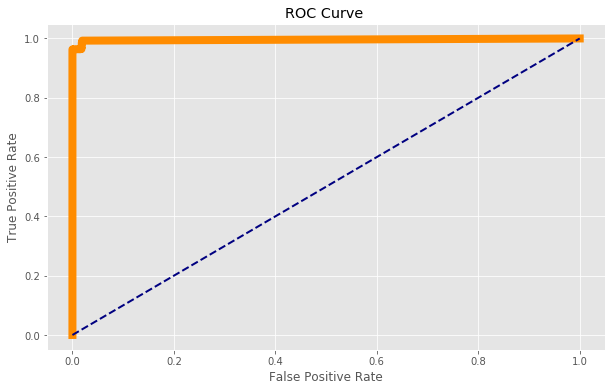

The area under the ROC curve is 0.995725


In [54]:
threshIter = 100 # Number of different thresholds to use for creating the ROC curve
plt.style.use('ggplot')
kwargs = {}
fig=plt.figure(figsize=(10,6))

# Get list of prediction probabilities for the test set
Y_test_proba = optClass.predict_proba(X_test)
# Go through and calculate probability of spam (in column 1) for each instance
Y_test_perc=np.zeros((Y_test_proba.shape[0],1))

for inst in range(Y_test_proba.shape[0]):
    # Below now holds probability of belonging to spam (normalied from 0 to 1)
    Y_test_perc[inst] = Y_test_proba[inst,1]/(Y_test_proba[inst,0]+Y_test_proba[inst,1])
threshList,precision_list,recall_list=generate_ROC_curve(Y_test,Y_test_pred,Y_test_perc,threshIter)

We now evaluate our prediction on the test set using multiple error metrics.

In [55]:
precision = find_precision(Y_test, Y_test_pred)
recall = find_recall(Y_test, Y_test_pred)
f1 = f1_score(Y_test, Y_test_pred)
accuracy,gen_error = find_accuracy(Y_test, Y_test_pred)
confusion_matrix = find_confusion_matrix(Y_test, Y_test_pred)

print('The Precision on the test set is: %f' %precision)
print('The Recall on the test set is: %f' %recall)
print("The F1-Score on the test set is: %f" %f1)
print("The Accuracy on the test set is: %f" %accuracy)
print('Below is the Confusion Matrix for the test set predictions:')
print(confusion_matrix)

The Precision on the test set is: 0.888889
The Recall on the test set is: 0.964539
The F1-Score on the test set is: 0.925170
The Accuracy on the test set is: 0.980251
Below is the Confusion Matrix for the test set predictions:
[[956.  17.]
 [  5. 136.]]


We now repeat the same process for a Multivariate Bernoulli Naive Bayes Classifier.<br>
However, this equations are actually the same as for a Multinomial Naive Bayes Classifier, except that for Multivariate Bernoulli even if a word occurs multiple times per message it is only weighted as once.<br>

We can therefore use the exact same code as we did for the Multinomial Naive Bayes Classifier.<br>
The only difference is that we will use the flag Binary=True when using CountVectorizer so repetitions are not allowed.

Here we choose which normalization to use.<br>
Choose carefully here as this is what will be used below.

In [56]:
# df_norm_bern = df # Unnormalized Messages
df_norm_bern = df_lemmatized # Lemmatized Messages
# df_norm_bern = df_stemmer_porter # Porter Stemmed Messages
# df_norm_bern = df_stemmer_lancaster # Lancaster Stemmed Messages
# df_norm_bern = df_lemmatized_porter # Lemmatized and Porter Stemmed Messages
# df_norm_bern = df_lemmatized_lancaster # Lemmatized and Porter Stemmed Messages
# df_norm_bern = df_porter_lancaster # Porter Stemmed and Lancaster Stemmed Messages

We now set binary to true in order to now not take into account the frequency in which words appear in each email.<br>
This is what will give us a Multivariate Bernoulli NB classifier instead of a Multinomial classifier.

In [57]:
vectorizer = CountVectorizer(stop_words='english',binary=True)
vectorizer.fit(df_norm_bern['Message'])

# Below is a numpy ndarray
# Each row is for a different message
# Each column is a unique word
feature_matrix_bern = vectorizer.transform(df_norm_bern['Message']).toarray()
print(feature_matrix_bern.shape)

(5574, 8471)


In [58]:
print(pd.DataFrame(feature_matrix_bern).describe())

              0            1            2            3            4     \
count  5574.000000  5574.000000  5574.000000  5574.000000  5574.000000   
mean      0.001794     0.004844     0.000179     0.000359     0.000179   
std       0.042322     0.069436     0.013394     0.018941     0.013394   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              5            6            7            8            9     ...  \
count  5574.000000  5574.000000  5574.000000  5574.000000  5574.000000  ...   
mean      0.000179     0.000179     0.000359     0.000179     0.001435  ...   
std       0.013394     0.013394     0.018941     0.013394     0.037861  ...   
min       0.00000

Create target vector as a numpy array

In [61]:
target_vector_bern = df_norm_bern['Label'].values.reshape(-1,1)

# We have a separate row for each message and only one column
print(target_vector_bern.shape)

(5574, 1)


Partition data into test and train

In [64]:
random_state = 42 # Used for seeding random generator in function
t = 0.20 # Fraction of data to keep in testing set

X_test_bern,X_train_bern,Y_test_bern,Y_train_bern = partition(feature_matrix_bern,target_vector_bern,t,random_state)

print(X_test_bern.shape)
print(X_train_bern.shape)
print(Y_test_bern.shape)
print(Y_train_bern.shape)

(1114, 8471)
(4458, 8471)
(1114, 1)
(4458, 1)


Perform K-Fold cross-validation on the training set using Multivariate Bernoulli Naive Bayes Classifier.<br>

In [65]:
# Perform k-fold cross-validation to find optimal hyperparameters

folds = 4 # Number of folds to use for cross validation
alpha_list = [0.1, 0.5, 1.0, 1.5, 2.0]
error_function = f1_score # Error function to use for evaluation

model_performance_list = np.empty([1,3]) # Initialize as empty
num_comb = len(alpha_list)
count = 1
error_fold_train = []
error_fold_test = []
for alpha in alpha_list:
    print('Looking at combination %i of %i' %(count,num_comb))
    count+=1
    model_name = MultiNomial_NB(alpha)
    model = [model_name.fit,model_name.predict]
    model_args = []
    dict_temp = kFold(folds, X_train_bern, Y_train_bern, model, model_args, error_function)
    error_fold_train = []
    error_fold_test = []
            
    for kk,jj in dict_temp.items():
        error_fold_train.append(jj[-1][0]) # Holds error for training sets
        error_fold_test.append(jj[-1][1]) # Holds error for testing sets
    eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
    std_error_train = np.std(np.asarray(error_fold_train))
    eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
    std_error_test = np.std(np.asarray(error_fold_test))
    # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
    model_performance_list=np.vstack((model_performance_list,[alpha,eavg_test,eavg_train]))

# Remove first row from model_performance_list as it contained the random values used to initialize it
model_performance_list=np.delete(model_performance_list, [0], axis=0)

# Save full output of s-fold cross-validation to disk for use in report
df_s_fold = pd.DataFrame(model_performance_list,columns=['Alpha', 'F1 Score-From Testing Sets','F1 Score-From Training Sets']) # Convert to pandas dataframe

print('\n')
print(df_s_fold)

# Replace any inf or nan with np.nan for dropping in next step
df_s_fold=df_s_fold.replace('inf', np.nan)
df_s_fold=df_s_fold.replace('nan', np.nan)
# Now drop all rows containing NaN
df_s_fold=df_s_fold.dropna()
print('\n')
print('Below are the values corresponding to the largest F1_Score from the testing sets during cross-validation')
# Now find row index corresponding to lowest MSE from testing sets
print(df_s_fold[df_s_fold['F1 Score-From Testing Sets']==df_s_fold['F1 Score-From Testing Sets'].max()])

Looking at combination 1 of 5
Looking at combination 2 of 5
Looking at combination 3 of 5
Looking at combination 4 of 5
Looking at combination 5 of 5


   Alpha  F1 Score-From Testing Sets  F1 Score-From Training Sets
0    0.1                    0.818919                     0.986351
1    0.5                    0.871032                     0.988063
2    1.0                    0.886295                     0.986790
3    1.5                    0.903682                     0.983034
4    2.0                    0.900616                     0.982044


Below are the values corresponding to the largest F1_Score from the testing sets during cross-validation
   Alpha  F1 Score-From Testing Sets  F1 Score-From Training Sets
3    1.5                    0.903682                     0.983034


For Unnormalized messages alpha_opt=0.1 with F1-Score=0.930 on test.<br>
For Lemmatized messages alpha_opt=0.1 with F1-Score=0.930 on test.<br>
For Porter Stemmed messages alpha_opt=0.1 with F1-Score=0.929 on test.<br>
For Lancaster Stemmed messages alpha_opt=0.1 with F1-Score=0.927 on test.<br>
For Lemmatized and Porter Stemmed messages alpha_opt=0.1 with F1-Score=0.929 on test.<br>
For Lemmatized and Lancester Stemmed messages alpha_opt=0.1 with F1-Score=0.927 on test.<br>
For Porter Stemmed and Lancaster Stemmed messages alpha_opt=0.1 with F1-Score=0.929 on test.<br>

From these results we see that using either no normalization or just lemmatizing provides the highest F1-Score.<br>
We choose to use Lemmatizing as logically this may lead to slightly improved generality.<br>
Thus, below we use Lemmatized messages with alpha=0.1.

In [66]:
alpha=0.1
optClass = MultiNomial_NB(alpha)
optClass.fit(X_train_bern,Y_train_bern)

Make predictions on the test set

In [67]:
Y_test_pred_bern = optClass.predict(X_test_bern)

Plot ROC Curve for our optimized model

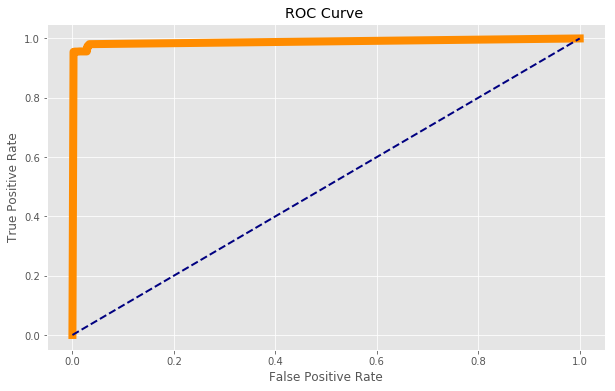

The area under the ROC curve is 0.988292


In [68]:
threshIter = 100 # Number of different thresholds to use for creating the ROC curve
plt.style.use('ggplot')
kwargs = {}
fig=plt.figure(figsize=(10,6))

# Get list of prediction probabilities for the test set
Y_test_proba_bern = optClass.predict_proba(X_test_bern)
# Go through and calculate probability of spam (in column 1) for each instance
Y_test_perc_bern=np.zeros((Y_test_proba_bern.shape[0],1))

for inst in range(Y_test_proba_bern.shape[0]):
    # Below now holds probability of belonging to spam (normalied from 0 to 1)
    Y_test_perc_bern[inst] = Y_test_proba_bern[inst,1]/(Y_test_proba_bern[inst,0]+Y_test_proba_bern[inst,1])
threshList,precision_list,recall_list=generate_ROC_curve(Y_test_bern,Y_test_pred_bern,Y_test_perc_bern,threshIter)
plt.show()

Now find and display error metrics for our test set

In [69]:
precision = find_precision(Y_test_bern, Y_test_pred_bern)
recall = find_recall(Y_test_bern, Y_test_pred_bern)
f1 = f1_score(Y_test_bern, Y_test_pred_bern)
accuracy,gen_error = find_accuracy(Y_test_bern, Y_test_pred_bern)
confusion_matrix = find_confusion_matrix(Y_test_bern, Y_test_pred_bern)
print('The Precision on the test set is: %f' %precision)
print('The Recall on the test set is: %f' %recall)
print("The F1-Score on the test set is: %f" %f1)
print("The Accuracy on the test set is: %f" %accuracy)
print('Below is the Confusion Matrix for the test set predictions:')
print(confusion_matrix)

The Precision on the test set is: 0.850000
The Recall on the test set is: 0.956250
The F1-Score on the test set is: 0.900000
The Accuracy on the test set is: 0.969479
Below is the Confusion Matrix for the test set predictions:
[[927.  27.]
 [  7. 153.]]


Interestingly, from the above results it appears that Multivariate Bernoulli Naive Bayes classification is only slightly worse than using Multinomial Naive Bayes. This indicates that taking into account the frequency of words does not make a huge difference with this dataset.<br>
That said, Multinomial Naive Bayes has slightly higher error metrics, and we would thus recommend that for classifying these messages Multivariate Naive Bayes with alpha=0.1 is used.